In [36]:
 #!/usr/bin/env python -W ignore
from __future__ import division, print_function, unicode_literals

import warnings
warnings.filterwarnings("ignore")

# Common imports
import numpy as np
import pandas as pd
from datetime import datetime
import os, sys
from statsmodels.tsa.arima_model import ARIMA
from pandas import DataFrame
from sklearn.metrics import mean_squared_error

%matplotlib inline
import matplotlib
import matplotlib.pyplot as plt
plt.rcParams['axes.labelsize'] = 14
plt.rcParams['xtick.labelsize'] = 12
plt.rcParams['ytick.labelsize'] = 12

gDataPath = '../data/D11-02/'

def save_img(fig_id, tight_layout=True):
    path = os.path.join("../images", fig_id + ".png")
    print("Saving figure", fig_id)
    if tight_layout:
        plt.tight_layout()
        plt.savefig(path, format='png', dpi=300)

In [4]:
def read_data():
    data_files = ['D11', 'D12', 'D01', 'D02']
    data = (pd.read_csv(os.path.join(gDataPath,f), sep=';', header=0) for f in data_files)
    concat_data = pd.concat(data, ignore_index=True)
    # Change the column name from chineses to english
    concat_data.columns = ['Transaction Date', 'Customer ID', 'Age', 'Residence Area', 'Product Subclass', 'Product ID', 'Amount', 'Asset', 'Sale Price'] 
    # Handle the time elements for Transaction Date
    concat_data['Transaction Date'] = pd.to_datetime(concat_data['Transaction Date'])
    concat_data.index = concat_data['Transaction Date']
    del concat_data['Transaction Date']
    return concat_data

In [5]:
pos_data = read_data()
pos_data.head(10)

,Customer ID,Age,Residence Area,Product Subclass,Product ID,Amount,Asset,Sale Price
Transaction Date,,,,,,,,
2000-11-01,46855,D,E,110411,4710085120468,3,51,57
2000-11-01,539166,E,E,130315,4714981010038,2,56,48
2000-11-01,663373,F,E,110217,4710265847666,1,180,135
2000-11-01,340625,A,E,110411,4710085120697,1,17,24
2000-11-01,236645,D,H,712901,8999002568972,2,128,170
2000-11-01,1704129,B,E,110407,4710734000011,1,38,46
2000-11-01,841528,C,E,110102,4710311107102,1,20,28
2000-11-01,768566,K,E,110401,4710088410382,1,44,55
2000-11-01,217361,F,E,130401,4711587809011,1,76,90


In [6]:
pos_data.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 817741 entries, 2000-11-01 to 2001-02-28
Data columns (total 8 columns):
Customer ID         817741 non-null int64
Age                 817741 non-null object
Residence Area      817741 non-null object
Product Subclass    817741 non-null int64
Product ID          817741 non-null int64
Amount              817741 non-null int64
Asset               817741 non-null int64
Sale Price          817741 non-null int64
dtypes: int64(6), object(2)
memory usage: 56.1+ MB


In [7]:
pos_data['2000-11'].info()
pos_data['2000-12'].info()
pos_data['2001-01'].info()
pos_data['2001-02'].info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 223622 entries, 2000-11-01 to 2000-11-30
Data columns (total 8 columns):
Customer ID         223622 non-null int64
Age                 223622 non-null object
Residence Area      223622 non-null object
Product Subclass    223622 non-null int64
Product ID          223622 non-null int64
Amount              223622 non-null int64
Asset               223622 non-null int64
Sale Price          223622 non-null int64
dtypes: int64(6), object(2)
memory usage: 15.4+ MB
<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 178216 entries, 2000-12-01 to 2000-12-31
Data columns (total 8 columns):
Customer ID         178216 non-null int64
Age                 178216 non-null object
Residence Area      178216 non-null object
Product Subclass    178216 non-null int64
Product ID          178216 non-null int64
Amount              178216 non-null int64
Asset               178216 non-null int64
Sale Price          178216 non-null int64
dtypes: int64(6), obj

In [8]:
pos_data["Product ID"].value_counts()

4714981010038    8476
4711271000014    6120
4719090900065    2444
4711080010112    2251
4710114128038    2181
4710265849066    2018
4713985863121    1976
4710088410139    1870
4710583996008    1840
4710908131589    1680
4710291112172    1641
4710011401128    1637
4710088410610    1632
4710036003581    1622
4712425010712    1620
4710421090059    1564
4710094097768    1448
4719090900058    1408
4710018004605    1391
4710114105046    1384
4710085120628    1357
4710114606048    1294
4711001302104    1242
20557003         1202
37000440147      1196
4710104111569    1166
4714381003128    1147
4710908131534    1143
8888021200256    1119
4710032501791    1113
                 ... 
4710644186225       1
4973167492345       1
20548094            1
4973655701928       1
4531632418346       1
4712545128014       1
4711703123021       1
4716369700227       1
4712292260067       1
4901126627323       1
4715833517132       1
4973167400135       1
4710431302265       1
4710982092172       1
4714082100

In [42]:
def prepare_data(pos_data, product_id):
    item_data = pos_data.filter(items=["Product ID"])[pos_data["Product ID"] == product_id]
    item_freq_data = item_data.groupby(item_data.index.date).count()
    item_freq_data.index = pd.to_datetime(item_freq_data.index)
    item_week_freq_data = item_freq_data.resample('W', how="sum")
    item_week_freq_data["Product ID"] = item_week_freq_data["Product ID"].astype(float)
    item_week_freq_data.head()
    return item_week_freq_data

prep_data = prepare_data(pos_data, 4711271000014)

Saving figure data_plot


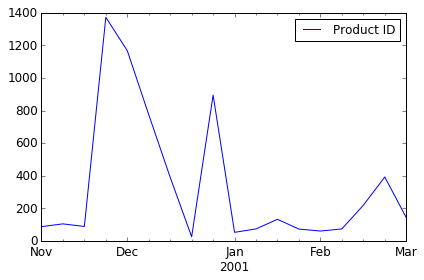

In [43]:
# Check the stationarity of the time series
prep_data.plot()
save_img("data_plot")

ADF Statistic: 0.000000
p-value: 0.958532
Critical Values:
	5%: -3.478
	1%: -4.939
	10%: -2.844


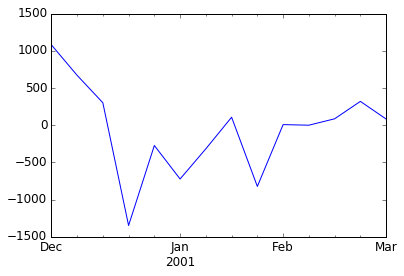

In [23]:
from statsmodels.tsa.stattools import adfuller
from pandas import Series


# create a differenced series
def difference(dataset, interval=1):
    diff = list()
    for i in range(interval, len(dataset)):
        value = dataset[i] - dataset[i - interval]
        diff.append(value)
    return Series(diff)

# difference data
weeks = 1
stationary = difference(prep_data.values, weeks)
stationary.index = prep_data.index[weeks:]
# check if stationary
result = adfuller(stationary)
print('ADF Statistic: %f' % result[0])
print('p-value: %f' % result[1])
print('Critical Values:')
for key, value in result[4].items():
    print('\t%s: %.3f' % (key, value))
# plot
stationary = stationary.astype(float)
stationary.plot()
plt.show()



Saving figure auto_plot


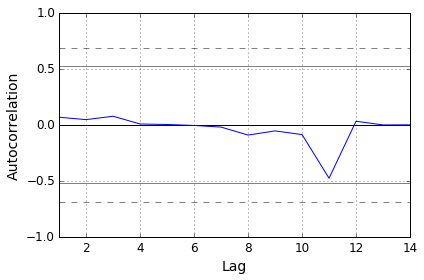

In [46]:
from pandas.tools.plotting import autocorrelation_plot
autocorrelation_plot(stationary)
save_img("auto_plot")
plt.show()
#save_img("auto_plot")
#we can see that there is a positive correlation with the first 2-to-4 lags that is perhaps significant for the first 5 lags.

#A good starting point for the AR parameter of the model may be 3.

In [47]:
def train_and_predict_model(data):
    X = data.values
    size = int(len(X) * 0.66)
    train, test = X[0:size], X[size:len(X)]
    train_values = [x for x in train]
    predictions = list()
    for t in range(len(test)):
        model = ARIMA(train_values, order=(3,1,0))
        model_fit = model.fit(disp=0)
        output = model_fit.forecast()
        yhat = output[0]
        predictions.append(yhat)
        obs = test[t]
        train_values.append(obs)
        print('predicted=%f, expected=%f' % (yhat, obs))
    error = mean_squared_error(test, predictions)
    print('Test MSE: %.3f' % error)
    # plot
    plt.plot(test)
    plt.plot(predictions, color='red')
    plt.show()

In [50]:
#Tune the ARIMA hyperparameters for a rolling one-step forecast
# GridSearch and evaluate an ARIMA model for a given order (p,d,q)
def evaluate_arima_model(X, arima_order, plot=0):
    # prepare training dataset
    train_size = int(len(X) * 0.66)
    train, test = X[0:train_size], X[train_size:]
    history = [x for x in train]
    # make predictions
    predictions = list()
    for t in range(len(test)):
        model = ARIMA(history, order=arima_order)
        model_fit = model.fit(disp=0)
        yhat = model_fit.forecast()[0]
        predictions.append(yhat)
        history.append(test[t])
    # calculate out of sample error
    error = mean_squared_error(test, predictions)
    if plot:
        plt.plot(test)
        plt.plot(predictions, color='red')
        save_img("prediction_plot")
        plt.show()
    return error

def evaluate_models(dataset, p_values, d_values, q_values):
    dataset = dataset.astype('float32')
    best_score, best_cfg = float("inf"), None
    for p in p_values:
        for d in d_values:
            for q in q_values:
                order = (p,d,q)
                try:
                    mse = evaluate_arima_model(dataset, order)
                    if mse < best_score:
                        best_score, best_cfg = mse, order
                        print('ARIMA%s MSE=%.3f' % (order,mse))
                except:
                    continue
    evaluate_arima_model(dataset, best_cfg, 1)
    print('Best ARIMA%s MSE=%.3f' % (best_cfg, best_score))


ADF Statistic: 0.000000
p-value: 0.958532
Critical Values:
	5%: -3.478
	1%: -4.939
	10%: -2.844
ARIMA(0, 0, 0) MSE=1784103.867
ARIMA(0, 1, 1) MSE=1368467.689
ARIMA(2, 1, 0) MSE=1278584.569
Saving figure prediction_plot


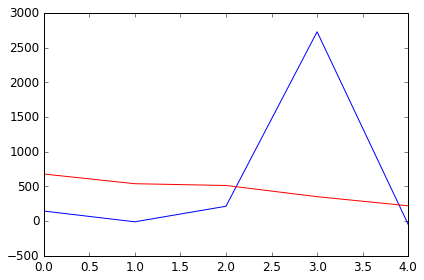

Best ARIMA(2, 1, 0) MSE=1278584.569


In [51]:
prep_data = prepare_data(pos_data, 4714981010038)

# difference data
weeks = 4
stationary = difference(prep_data.values, weeks)
stationary.index = prep_data.index[weeks:]
# check if stationary
result = adfuller(stationary)
print('ADF Statistic: %f' % result[0])
print('p-value: %f' % result[1])
print('Critical Values:')
for key, value in result[4].items():
    print('\t%s: %.3f' % (key, value))
# plot
stationary = stationary.astype(float)

# evaluate parameters
p_values = [0, 1, 2, 4, 6, 8, 10]
d_values = range(0, 3)
q_values = range(0, 3)
evaluate_models(stationary.values, p_values, d_values, q_values)
#train_and_predict_model(prep_data)